> Intelligent Pattern Recognition, EE798R

##### *October 20th, 2024*

# Project Paper 1 (TIMNET) - T-SNE Charts

**Kartik Anant Kulkarni (Section C, Roll no. 210493)**

## Imports

In [1]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.layers import (
    Conv1D,
    SpatialDropout1D,
    add,
    GlobalAveragePooling1D,
)
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import sigmoid

In [2]:
import numpy as np
import tensorflow.keras.backend as K
import os
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Layer, Dense, Input
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import datetime
import pandas as pd
import copy

import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import argparse
import sys

## Model, Layer Definition and Helper Functions

In [3]:
class Common_Model(object):
    def __init__(self, save_path: str = "", name: str = "Not Specified"):
        self.model = None
        self.trained = False

    def train(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError()

    def predict(self, samples):
        raise NotImplementedError()

    def predict_proba(self, samples):
        if not self.trained:
            sys.stderr.write("No Model.")
            sys.exit(-1)
        return self.model.predict_proba(samples)

    def save_model(self, model_name: str):
        raise NotImplementedError()

In [4]:
def Temporal_Aware_Block(
    x, s, i, activation, nb_filters, kernel_size, dropout_rate=0, name=""
):
    original_x = x
    # 1.1
    conv_1_1 = Conv1D(
        filters=nb_filters, kernel_size=kernel_size, dilation_rate=i, padding="causal"
    )(x)
    conv_1_1 = BatchNormalization(trainable=True, axis=-1)(conv_1_1)
    conv_1_1 = Activation(activation)(conv_1_1)
    output_1_1 = SpatialDropout1D(dropout_rate)(conv_1_1)
    # 2.1
    conv_2_1 = Conv1D(
        filters=nb_filters, kernel_size=kernel_size, dilation_rate=i, padding="causal"
    )(output_1_1)
    conv_2_1 = BatchNormalization(trainable=True, axis=-1)(conv_2_1)
    conv_2_1 = Activation(activation)(conv_2_1)
    output_2_1 = SpatialDropout1D(dropout_rate)(conv_2_1)

    if original_x.shape[-1] != output_2_1.shape[-1]:
        original_x = Conv1D(filters=nb_filters, kernel_size=1, padding="same")(
            original_x
        )

    output_2_1 = Lambda(sigmoid)(output_2_1)
    F_x = Lambda(lambda x: tf.multiply(x[0], x[1]))([original_x, output_2_1])
    return F_x

In [5]:
class TIMNET:
    def __init__(
        self,
        nb_filters=64,
        kernel_size=2,
        nb_stacks=1,
        dilations=None,
        activation="relu",
        dropout_rate=0.1,
        return_sequences=True,
        name="TIMNET",
    ):
        self.name = name
        self.return_sequences = return_sequences
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters

        self.supports_masking = True
        self.mask_value = 0.0

        if not isinstance(nb_filters, int):
            raise Exception()

    def __call__(self, inputs, mask=None):
        if self.dilations is None:
            self.dilations = 8
        forward = inputs
        backward = K.reverse(inputs, axes=1)

        print("Input Shape=", inputs.shape)
        forward_convd = Conv1D(
            filters=self.nb_filters, kernel_size=1, dilation_rate=1, padding="causal"
        )(forward)
        backward_convd = Conv1D(
            filters=self.nb_filters, kernel_size=1, dilation_rate=1, padding="causal"
        )(backward)

        final_skip_connection = []

        skip_out_forward = forward_convd
        skip_out_backward = backward_convd

        for s in range(self.nb_stacks):
            for i in [2**i for i in range(self.dilations)]:
                skip_out_forward = Temporal_Aware_Block(
                    skip_out_forward,
                    s,
                    i,
                    self.activation,
                    self.nb_filters,
                    self.kernel_size,
                    self.dropout_rate,
                    name=self.name,
                )
                skip_out_backward = Temporal_Aware_Block(
                    skip_out_backward,
                    s,
                    i,
                    self.activation,
                    self.nb_filters,
                    self.kernel_size,
                    self.dropout_rate,
                    name=self.name,
                )

                temp_skip = add(
                    [skip_out_forward, skip_out_backward], name="biadd_" + str(i)
                )
                temp_skip = GlobalAveragePooling1D()(temp_skip)
                temp_skip = tf.expand_dims(temp_skip, axis=1)
                final_skip_connection.append(temp_skip)

        output_2 = final_skip_connection[0]
        for i, item in enumerate(final_skip_connection):
            if i == 0:
                continue
            output_2 = K.concatenate([output_2, item], axis=-2)
        x = output_2

        return x

In [6]:
def smooth_labels(labels, factor=0.1):
    # smooth the labels
    labels *= 1 - factor
    labels += factor / labels.shape[1]
    return labels

In [7]:
class WeightLayer(Layer):
    def __init__(self, **kwargs):
        super(WeightLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=(input_shape[1], 1),
            initializer="uniform",
            trainable=True,
        )
        super(WeightLayer, self).build(input_shape)

    def call(self, x):
        tempx = tf.transpose(x, [0, 2, 1])
        x = K.dot(tempx, self.kernel)
        x = tf.squeeze(x, axis=-1)
        return x

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

In [8]:
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

In [9]:
train_loss_list = []
val_loss_list = []
val_acc_list = []
training_acc_list = []

In [10]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, weight_path, save_freq=5, save_best_only=False):
        super(CustomModelCheckpoint, self).__init__()
        self.weight_path = weight_path
        self.save_freq = save_freq
        self.save_best_only = save_best_only
        self.best_weights = None
        self.best_val_loss = float("inf")

    def on_epoch_end(self, epoch, logs=None):
        # Save every `self.save_freq` epochs
        train_loss_list.append((epoch, logs.get("loss")))
        val_loss_list.append((epoch, logs.get("val_loss")))
        val_acc_list.append((epoch, logs.get("val_accuracy")))
        training_acc_list.append((epoch, logs.get("accuracy")))

        if (epoch + 1) % self.save_freq == 0:
            if self.save_best_only:
                val_loss = logs.get("val_loss")
                if val_loss is not None and val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    print(
                        f"\nEpoch {epoch + 1}: val_loss improved to {self.best_val_loss}, saving model"
                    )
                    self.model.save_weights(self.weight_path)
                    self.best_weights = self.model.get_weights()  # Store best weights
                else:
                    print(
                        f"\nEpoch {epoch + 1}: val_loss did not improve, skipping save"
                    )
            else:
                print(f"\nEpoch {epoch + 1}: saving model")
                self.model.save_weights(self.weight_path)
        else:
            print(f"\nEpoch {epoch + 1}: No save this epoch")

In [11]:
class TIMNET_Model(Common_Model):
    def __init__(self, args, input_shape, class_label, **params):
        super(TIMNET_Model, self).__init__(**params)
        self.args = args
        self.data_shape = input_shape
        self.num_classes = len(class_label)
        self.class_label = class_label
        self.matrix = []
        self.eva_matrix = []
        self.acc = 0
        print("TIMNET MODEL SHAPE:", input_shape)

    def create_model(self):
        self.inputs = Input(shape=(self.data_shape[0], self.data_shape[1]))
        self.multi_decision = TIMNET(
            nb_filters=self.args.filter_size,
            kernel_size=self.args.kernel_size,
            nb_stacks=self.args.stack_size,
            dilations=self.args.dilation_size,
            dropout_rate=self.args.dropout,
            activation=self.args.activation,
            return_sequences=True,
            name="TIMNET",
        )(self.inputs)

        self.decision = WeightLayer()(self.multi_decision)
        self.predictions = Dense(self.num_classes, activation="softmax")(self.decision)
        self.model = Model(inputs=self.inputs, outputs=self.predictions)

        self.model.compile(
            loss="categorical_crossentropy",
            optimizer=Adam(
                learning_rate=self.args.lr,
                beta_1=self.args.beta1,
                beta_2=self.args.beta2,
                epsilon=1e-8,
            ),
            metrics=["accuracy"],
        )
        print("Temporal create succes!")

    def train(self, x, y):
        train_loss_list = []
        val_loss_list = []
        val_acc_list = []
        training_acc_list = []

        filepath = self.args.model_path
        resultpath = self.args.result_path

        if not os.path.exists(filepath):
            os.mkdir(filepath)
        if not os.path.exists(resultpath):
            os.mkdir(resultpath)

        i = 1
        now = datetime.datetime.now()
        now_time = datetime.datetime.strftime(now, "%Y-%m-%d_%H-%M-%S")
        kfold = KFold(
            n_splits=self.args.split_fold,
            shuffle=True,
            random_state=self.args.random_seed,
        )
        avg_accuracy = 0
        avg_loss = 0
        for train, test in kfold.split(x, y):
            self.create_model()
            y_train = smooth_labels(copy.deepcopy(y[train]), 0.1)
            folder_address = (
                filepath
                + self.args.data
                + "_"
                + str(self.args.random_seed)
                + "_"
                + now_time
            )
            if not os.path.exists(folder_address):
                os.mkdir(folder_address)
            weight_path = (
                folder_address
                + "/"
                + str(self.args.split_fold)
                + "-fold_weights_best_"
                + str(i)
                + ".hdf5"
            )
            # checkpoint = callbacks.ModelCheckpoint(
            #     weight_path, verbose=1, save_weights_only=True, save_best_only=True
            # )
            checkpoint = CustomModelCheckpoint(
                weight_path=weight_path, save_freq=2, save_best_only=True
            )
            max_acc = 0
            best_eva_list = []
            h = self.model.fit(
                x[train],
                y_train,
                validation_data=(x[test], y[test]),
                batch_size=self.args.batch_size,
                epochs=self.args.epoch,
                verbose=1,
                callbacks=[checkpoint],
            )
            self.model.load_weights(weight_path)
            best_eva_list = self.model.evaluate(x[test], y[test])
            avg_loss += best_eva_list[0]
            avg_accuracy += best_eva_list[1]
            print(
                str(i) + "_Model evaluation: ",
                best_eva_list,
                "   Now ACC:",
                str(round(avg_accuracy * 10000) / 100 / i),
            )
            i += 1
            y_pred_best = self.model.predict(x[test])
            self.matrix.append(
                confusion_matrix(
                    np.argmax(y[test], axis=1), np.argmax(y_pred_best, axis=1)
                )
            )
            em = classification_report(
                np.argmax(y[test], axis=1),
                np.argmax(y_pred_best, axis=1),
                target_names=self.class_label,
                output_dict=True,
            )
            self.eva_matrix.append(em)
            print(
                classification_report(
                    np.argmax(y[test], axis=1),
                    np.argmax(y_pred_best, axis=1),
                    target_names=self.class_label,
                )
            )

        print("Average ACC:", avg_accuracy / self.args.split_fold)
        self.acc = avg_accuracy / self.args.split_fold
        writer = pd.ExcelWriter(
            resultpath
            + self.args.data
            + "_"
            + str(self.args.split_fold)
            + "fold_"
            + str(round(self.acc * 10000) / 100)
            + "_"
            + str(self.args.random_seed)
            + "_"
            + now_time
            + ".xlsx"
        )
        for i, item in enumerate(self.matrix):
            temp = {}
            temp[" "] = self.class_label
            for j, l in enumerate(item):
                temp[self.class_label[j]] = item[j]
            data1 = pd.DataFrame(temp)
            data1.to_excel(writer, sheet_name=str(i))  # ), encoding="utf8")

            df = pd.DataFrame(self.eva_matrix[i]).transpose()
            df.to_excel(writer, sheet_name=str(i) + "_evaluate")  # , encoding='utf8')
        # writer.save()
        writer.close()

        K.clear_session()
        self.matrix = []
        self.eva_matrix = []
        self.acc = 0
        self.trained = True

    def test(self, x, y, path):
        i = 1
        kfold = KFold(
            n_splits=self.args.split_fold,
            shuffle=True,
            random_state=self.args.random_seed,
        )
        avg_accuracy = 0
        avg_loss = 0
        x_feats = []
        y_labels = []
        for train, test in kfold.split(x, y):
            self.create_model()
            weight_path = (
                path
                + "/"
                + str(self.args.split_fold)
                + "-fold_weights_best_"
                + str(i)
                + ".hdf5"
            )
            self.model.fit(
                x[train],
                y[train],
                validation_data=(x[test], y[test]),
                batch_size=64,
                epochs=0,
                verbose=0,
            )
            self.model.load_weights(weight_path)  # +source_name+'_single_best.hdf5')
            best_eva_list = self.model.evaluate(x[test], y[test])
            avg_loss += best_eva_list[0]
            avg_accuracy += best_eva_list[1]
            print(
                str(i) + "_Model evaluation: ",
                best_eva_list,
                "   Now ACC:",
                str(round(avg_accuracy * 10000) / 100 / i),
            )
            i += 1
            y_pred_best = self.model.predict(x[test])
            self.matrix.append(
                confusion_matrix(
                    np.argmax(y[test], axis=1), np.argmax(y_pred_best, axis=1)
                )
            )
            em = classification_report(
                np.argmax(y[test], axis=1),
                np.argmax(y_pred_best, axis=1),
                target_names=self.class_label,
                output_dict=True,
            )
            self.eva_matrix.append(em)
            print(
                classification_report(
                    np.argmax(y[test], axis=1),
                    np.argmax(y_pred_best, axis=1),
                    target_names=self.class_label,
                )
            )
            caps_layer_model = Model(
                inputs=self.model.input, outputs=self.model.get_layer(index=-2).output
            )
            feature_source = caps_layer_model.predict(x[test])
            x_feats.append(feature_source)
            y_labels.append(y[test])
        print("Average ACC:", avg_accuracy / self.args.split_fold)
        self.acc = avg_accuracy / self.args.split_fold
        return x_feats, y_labels

## Set Hyperparameters

Put all the processed MFCCs in the MFCC folder. Replace the following hyperparameters based on the chosen dataset using the table below. The other hyperparameters can be left as it is based on their default value.

| data | beta1 | beta2 | batch_size | epoch | dropout | split_fold |
| ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| CASIA | 0.93 | 0.98 | 512 | 500 | 0.1 | 8 |
| SAVEE | 0.93 | 0.98 | 512 | 600 | 0.12 | 8 |
| EMODB | 0.96 | 0.99 | 512 | 600 | 0.1 | 10 |
| RAVDE | 0.92 | 0.99 | 512 | 600 | 0.13 | 10 |
| EMOVO | 0.96 | 0.99 | 512 | 600 | 0.1 | 10 |
| IEMOCAP | 0.96 | 0.99 | 512 | 200 | 0.1 | 2 |

In [12]:
parser = argparse.ArgumentParser()

parser.add_argument("--mode", type=str, default="train")
parser.add_argument("--model_path", type=str, default="./Models/")
parser.add_argument("--result_path", type=str, default="./Results/")
parser.add_argument("--test_path", type=str, default="./Test_Models/EMODB_46")
parser.add_argument("--data", type=str, default="SAVEE")
parser.add_argument("--lr", type=float, default=0.001)
parser.add_argument("--beta1", type=float, default=0.93)
parser.add_argument("--beta2", type=float, default=0.98)
parser.add_argument("--batch_size", type=int, default=512)
parser.add_argument("--epoch", type=int, default=600)
parser.add_argument("--dropout", type=float, default=0.12)
parser.add_argument("--random_seed", type=int, default=46)
parser.add_argument("--activation", type=str, default="relu")
# parser.add_argument("--filter_size", type=int, default=39)
parser.add_argument(
    "--dilation_size", type=int, default=8
)  # If you want to train model on IEMOCAP, you should modify this parameter to 10 due to the long duration of speech signals.
parser.add_argument("--kernel_size", type=int, default=2)
parser.add_argument("--stack_size", type=int, default=1)
parser.add_argument("--split_fold", type=int, default=8)
parser.add_argument("--gpu", type=str, default="0")

# args = parser.parse_args()
args, _ = parser.parse_known_args()

# Check if filter_size is throwing an issue when added
try:
    if hasattr(args, "filter_size"):
        filter_size = args.filter_size
    else:
        args.filter_size = 39
except Exception as e:
    print(f"Error with filter_size: {e}")
print(f"Filter Size: {args.filter_size}")

if args.data == "IEMOCAP" and args.dilation_size != 10:
    args.dilation_size = 10

Filter Size: 39


## Configure Tensorflow

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
print(f"###gpus:{gpus}")

###gpus:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-10-21 12:06:45.432337: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-10-21 12:06:45.432377: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-21 12:06:45.432387: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-21 12:06:45.432453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-21 12:06:45.432674: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
import tensorflow as tf

# List all physical devices recognized by TensorFlow
physical_devices = tf.config.list_physical_devices()
print("Physical devices detected by TensorFlow:")
for device in physical_devices:
    print(device)

# Check specifically for GPU devices
gpu_devices = tf.config.list_physical_devices("GPU")
if gpu_devices:
    print("\nGPU device(s) available:")
    for gpu in gpu_devices:
        print(gpu)
else:
    print("\nNo GPU devices found.")

Physical devices detected by TensorFlow:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

GPU device(s) available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [15]:
CLASS_LABELS_finetune = ("angry", "fear", "happy", "neutral", "sad")
CASIA_CLASS_LABELS = ("angry", "fear", "happy", "neutral", "sad", "surprise")  # CASIA
EMODB_CLASS_LABELS = (
    "angry",
    "boredom",
    "disgust",
    "fear",
    "happy",
    "neutral",
    "sad",
)  # EMODB
SAVEE_CLASS_LABELS = (
    "angry",
    "disgust",
    "fear",
    "happy",
    "neutral",
    "sad",
    "surprise",
)  # SAVEE
RAVDE_CLASS_LABELS = (
    "angry",
    "calm",
    "disgust",
    "fear",
    "happy",
    "neutral",
    "sad",
    "surprise",
)  # rav
IEMOCAP_CLASS_LABELS = ("angry", "happy", "neutral", "sad")  # iemocap
EMOVO_CLASS_LABELS = (
    "angry",
    "disgust",
    "fear",
    "happy",
    "neutral",
    "sad",
    "surprise",
)  # emovo
CLASS_LABELS_dict = {
    "CASIA": CASIA_CLASS_LABELS,
    "EMODB": EMODB_CLASS_LABELS,
    "EMOVO": EMOVO_CLASS_LABELS,
    "IEMOCAP": IEMOCAP_CLASS_LABELS,
    "RAVDE": RAVDE_CLASS_LABELS,
    "SAVEE": SAVEE_CLASS_LABELS,
}

In [16]:
data = np.load("./MFCC/" + args.data + ".npy", allow_pickle=True).item()
x_source = data["x"]
y_source = data["y"]
CLASS_LABELS = CLASS_LABELS_dict[args.data]


model = TIMNET_Model(
    args=args, input_shape=x_source.shape[1:], class_label=CLASS_LABELS
)

TIMNET MODEL SHAPE: (254, 39)


Input Shape= (None, 254, 39)


2024-10-21 12:06:45.566416: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-21 12:06:45.566438: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Temporal create succes!


2024-10-21 12:06:46.999039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 3s 73ms/step


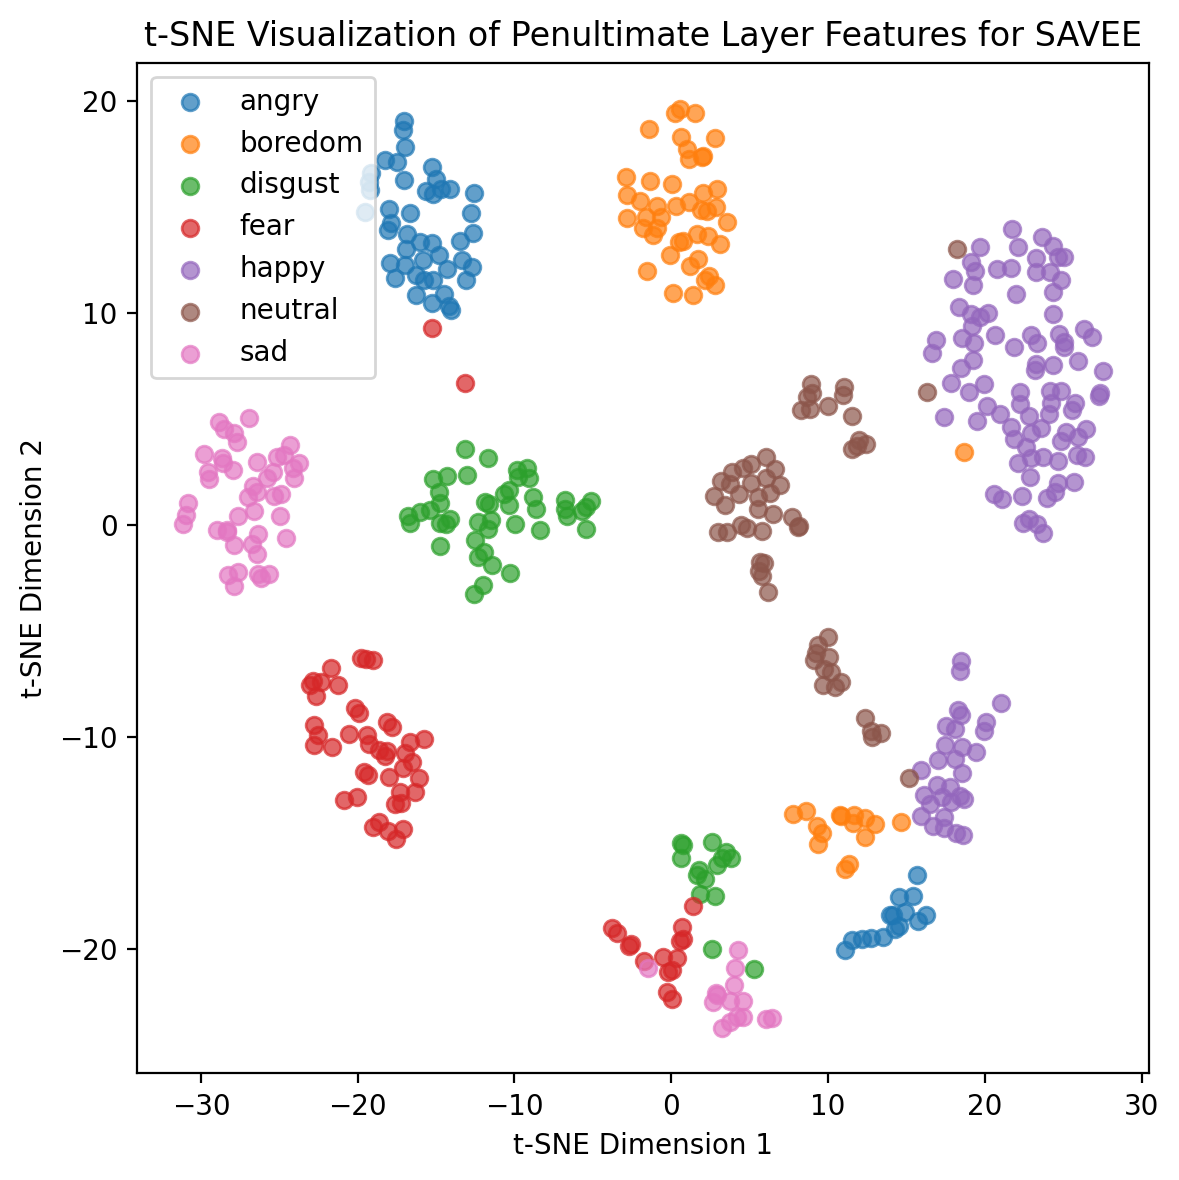

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model


def extract_features_from_model(model, x_data, layer_name=None):
    """
    Extract features from a specified layer of the trained model.
    """
    feature_model = Model(inputs=model.inputs, outputs=model.decision)
    features = feature_model.predict(x_data)
    return features


def plot_tsne(features, labels, class_names):
    """
    Apply t-SNE to the features and plot them in 2D space.
    """
    # Normalize features before applying t-SNE
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply t-SNE for 2D visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features_scaled)

    # Plotting the t-SNE results
    plt.figure(figsize=(6, 6), dpi=200)
    for i, class_name in enumerate(class_names):
        indices = np.where(labels == i)
        plt.scatter(
            tsne_features[indices, 0],
            tsne_features[indices, 1],
            label=class_name,
            alpha=0.7,
        )

    plt.title("t-SNE Visualization of Penultimate Layer Features for " + args.data)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.tight_layout()
    plt.savefig("./logs/" + args.data + "_t-SNE.png")
    plt.show()


model.create_model()
model.model.load_weights("Models/SAVEE/8-fold_weights_best_8.hdf5")

features = extract_features_from_model(model, x_source)
plot_tsne(
    features,
    np.argmax(y_source, axis=1),
    class_names=["angry", "boredom", "disgust", "fear", "happy", "neutral", "sad"],
)